# Part 1: The Invariant Mass Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load in Atlas Data
data = np.loadtxt("atlas_z_to_ll.csv", delimiter=',', skiprows=1)

pt1 = data[:,0]
pt2 = data[:,1]

eta1 = data[:,2]
eta2 = data[:,3]

phi1 = data[:,4]
phi2 = data[:,5]

E1 = data[:,6]
E2 = data[:,7]

In [2]:
# Compute 3-Momentum Components
def p_comp(pt, phi, eta):
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = pt*np.sinh(eta) 

    return px, py, pz

# 3-Momentum for Each Lepton
px1, py1, pz1 = p_comp(pt1,phi1,eta1)

px2, py2, pz2 = p_comp(pt2,phi2,eta2)

# Total System 4-momentum
E_tot = E1 + E2
px_tot = px1 + px2
py_tot = py1 + py2
pz_tot = pz1 + pz2


# Compute Invariant Mass
def inv_mass(E, px, py, pz):
    M = np.sqrt( E**2 - (px**2 + py**2 + pz**2) )
    return M

M = inv_mass(E_tot, px_tot, py_tot, pz_tot)

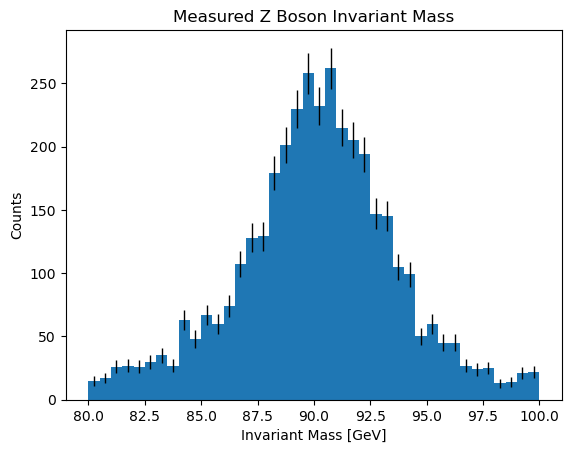

In [3]:
# Plot Histogram
fig, ax = plt.subplots()
bins = np.linspace(80, 100, 41)

h = ax.hist(M, bins=bins) # tuple: (n, bins, patches)
ax.set_xlabel("Invariant Mass [GeV]")
ax.set_ylabel("Counts")
ax.set_title("Measured Z Boson Invariant Mass")

# Plot Errorbars

# Compute error for each bin
errs = np.sqrt(h[0])

# Compute x-val of the middle of each bar
x_bins = h[1] + 0.5*( ( h[1][-1] - h[1][0] ) / len(h[1]) )
x_bins = np.delete(x_bins, -1)

# Plot Errorbars with vlines()
lb = h[0] - errs # Lower Bound
ub = h[0] + errs # Upper Bound
ax.vlines(x_bins, ymin=lb, ymax=ub, colors='k', linewidths=1);


# Part 2: Breit-Wigner Fit

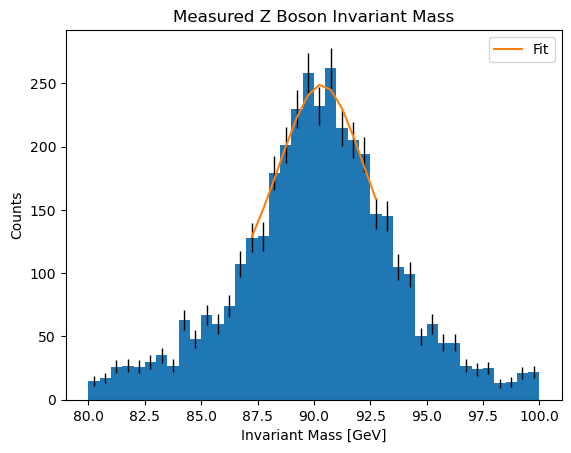

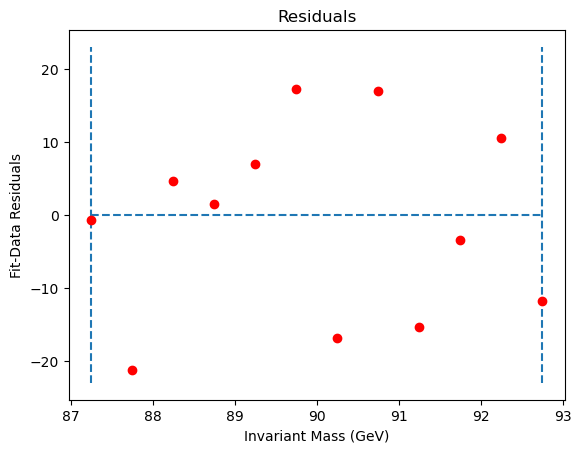

In [4]:
# Define Decay Distribution Function
def BW_fit(m, m0, Gamma):
    return ( 5000/(2*np.pi) ) * (  (Gamma/2)  /  ( (m-m0)**2 + (Gamma/2)**2 )  )

# Evaluate Fit
from scipy.optimize import curve_fit

# Define range to fit (87 - 93)
mask = (x_bins > 87) & (x_bins < 93)

x_data = np.array([])
for i in range(len(mask)):
    if mask[i] == True:
        x_data = np.append(x_data, x_bins[i])

y_data = np.array([])
for i in range(len(mask)):
    if mask[i] == True:
        y_data = np.append(y_data, h[0][i])

e_data = np.array([])
for i in range(len(mask)):
    if mask[i] == True:
        e_data = np.append(e_data, errs[i])

# Compute Fit Parameters
fit_par, pcov = curve_fit(BW_fit, xdata=x_data, ydata=y_data, sigma=e_data)

m0_fit = fit_par[0]
Gamma_fit = fit_par[1]


# Plot Fit over Data
fig, ax = plt.subplots()
ax.hist(M, bins=bins) # tuple: (n, bins, patches)
ax.set_xlabel("Invariant Mass [GeV]")
ax.set_ylabel("Counts")
ax.set_title("Measured Z Boson Invariant Mass")

ax.vlines(x_bins, ymin=lb, ymax=ub, colors='k', linewidths=1);

ax.plot(x_data, BW_fit(x_data, m0_fit, Gamma_fit), label="Fit")
plt.legend()


# Plot Residuals
figr, axr = plt.subplots()
axr.hlines(0, x_data[0], x_data[-1], ls='--') # Zero line
axr.vlines(x_data[0], ymin=-23, ymax=23, ls='--')
axr.vlines(x_data[-1], ymin=-23, ymax=23, ls='--')

res = y_data - BW_fit(x_data, m0_fit, Gamma_fit)
axr.plot(x_data, res, "or")
axr.set_title("Residuals")
axr.set_xlabel("Invariant Mass (GeV)")
axr.set_ylabel("Fit-Data Residuals");

In [5]:
# Calculate Chi-Squared, Reduced Chi-Squared, and P-value
import scipy.stats as st

chi2 = ( res**2 / e_data**2 ).sum()
dof = len(x_data) - 2 # 2 Fit params

red_chi2 = chi2 / dof
pval = st.chi2.sf(chi2, dof)

print(f"Chi-Squared: {chi2:.3f} \n\
Reduced Chi-Squared: {red_chi2:.3f} \n\
P-value: {pval:.3f}")

Chi-Squared: 9.985 
Reduced Chi-Squared: 0.999 
P-value: 0.442


In [6]:
m0_unc = np.sqrt(np.diag(pcov))[0]
print(f"m0 = {m0_fit:.3f} +- {m0_unc:.3f} GeV")

m0 = 90.335 +- 0.093 GeV


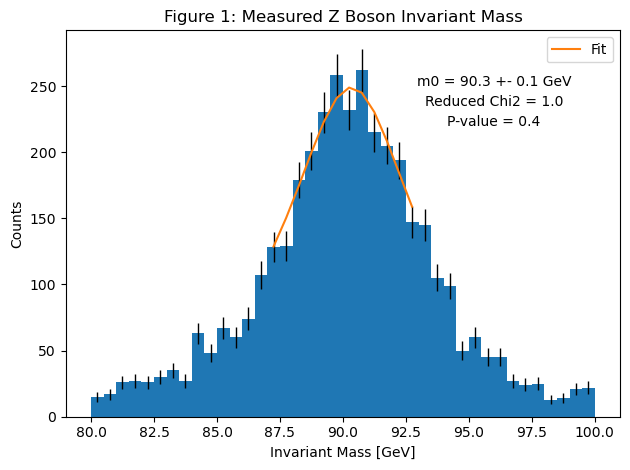

In [7]:
# Plot Fit over Data
fig, ax = plt.subplots()
ax.hist(M, bins=bins) # tuple: (n, bins, patches)
ax.set_xlabel("Invariant Mass [GeV]")
ax.set_ylabel("Counts")
ax.set_title("Figure 1: Measured Z Boson Invariant Mass")

ax.vlines(x_bins, ymin=lb, ymax=ub, colors='k', linewidths=1);

ax.plot(x_data, BW_fit(x_data, m0_fit, Gamma_fit), label="Fit")
plt.legend()

plt.annotate(text=f"m0 = {m0_fit:.1f} +- {m0_unc:.1f} GeV", xy=(96,250),
             horizontalalignment='center')
plt.annotate(text=f"Reduced Chi2 = {red_chi2:.1f}", xy=(96, 235),
             horizontalalignment='center')
plt.annotate(text=f"P-value = {pval:.1f}", xy=(96, 220),
             horizontalalignment='center')

plt.tight_layout()

# Part 3: 2D Parameter Contours

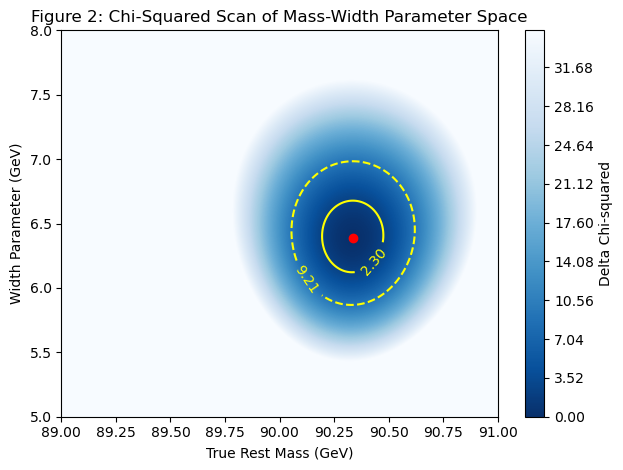

In [8]:
nbins = 300
chimap = np.zeros((nbins, nbins))

# Define range of parameters to test
m0_scan = np.linspace(89, 91, nbins) # [GeV]
gamma_scan = np.linspace(5, 8, nbins) # [GeV]


# Construct 2D Chi2 Scan
for i in range(nbins):
    for j in range(nbins):
        theory = BW_fit(x_data, m0_scan[i], gamma_scan[j])
        chi2 = np.sum( (theory - y_data)**2 / e_data**2 )
        chimap[j,i] = chi2

# Plot
chi_min = np.min(chimap)
chimap = np.clip(chimap, chi_min, chi_min+35) # clip to 35 (sets any value greater than 35 to 35)
delta_chi_map = chimap - chi_min

X, Y = np.meshgrid(m0_scan, gamma_scan)
fig2, ax2 = plt.subplots()

cs = ax2.contourf(X, Y, delta_chi_map, 500, cmap="Blues_r")
ax2.set_xlabel("True Rest Mass (GeV)")
ax2.set_ylabel("Width Parameter (GeV)")
ax2.set_title("Figure 2: Chi-Squared Scan of Mass-Width Parameter Space")

cbar = fig2.colorbar(cs, ax=ax2)
cbar.set_label("Delta Chi-squared")


# For 2 DOF, 3sigma Chi2 = 9.21, 1Sigma = 2.30
levels = [2.3, 9.21]
CS = ax2.contour(X, Y, delta_chi_map, levels=levels, colors=['yellow', 'yellow'], linestyles=['solid', 'dashed'])
ax2.clabel(CS, levels=[2.3, 9.21])

# Plot Best Fit
ax2.plot(m0_fit, Gamma_fit, "or")

plt.tight_layout()